In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

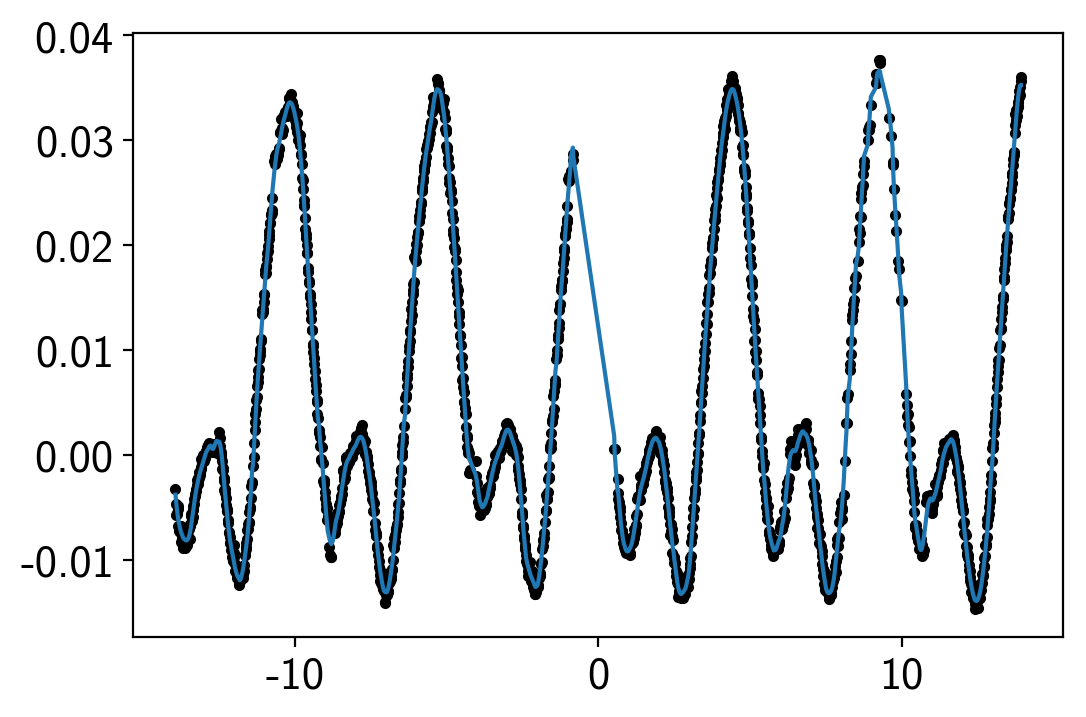

In [3]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

lc_url = "https://archive.stsci.edu/missions/tess/tid/s0001/0000/0004/4142/0236/tess2018206045859-s0001-0000000441420236-0120-s_lc.fits"
with fits.open(lc_url) as hdus:
    lc = hdus[1].data
    lc_hdr = hdus[1].header

texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
time = lc["TIME"]
flux = lc["PDCSAP_FLUX"]
flux_err = lc["PDCSAP_FLUX_ERR"]
m = np.isfinite(time) & np.isfinite(flux) & (lc["QUALITY"] == 0)
time = time[m]
flux = flux[m]
flux_err = flux_err[m]

# Identify outliers
m = np.ones(len(flux), dtype=bool)
for i in range(10):
    y_prime = np.interp(time, time[m], flux[m])
    smooth = savgol_filter(y_prime, 301, polyorder=3)
    resid = flux - smooth
    sigma = np.sqrt(np.mean(resid**2))
    m0 = np.abs(resid) < sigma
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0

# Just for this demo, subsample the data
ref_time = 0.5 * (np.min(time[m])+np.max(time[m]))
time = np.ascontiguousarray(time[m][::10] - ref_time, dtype=np.float64)
flux = np.ascontiguousarray(flux[m][::10], dtype=np.float64)
flux_err = np.ascontiguousarray(flux_err[m][::10], dtype=np.float64)

mu = np.median(flux)
flux = flux / mu - 1
flux_err /= mu

x = time
y = flux
yerr = flux_err

plt.plot(time, flux, ".k")
plt.plot(time, smooth[m][::10] / mu - 1);

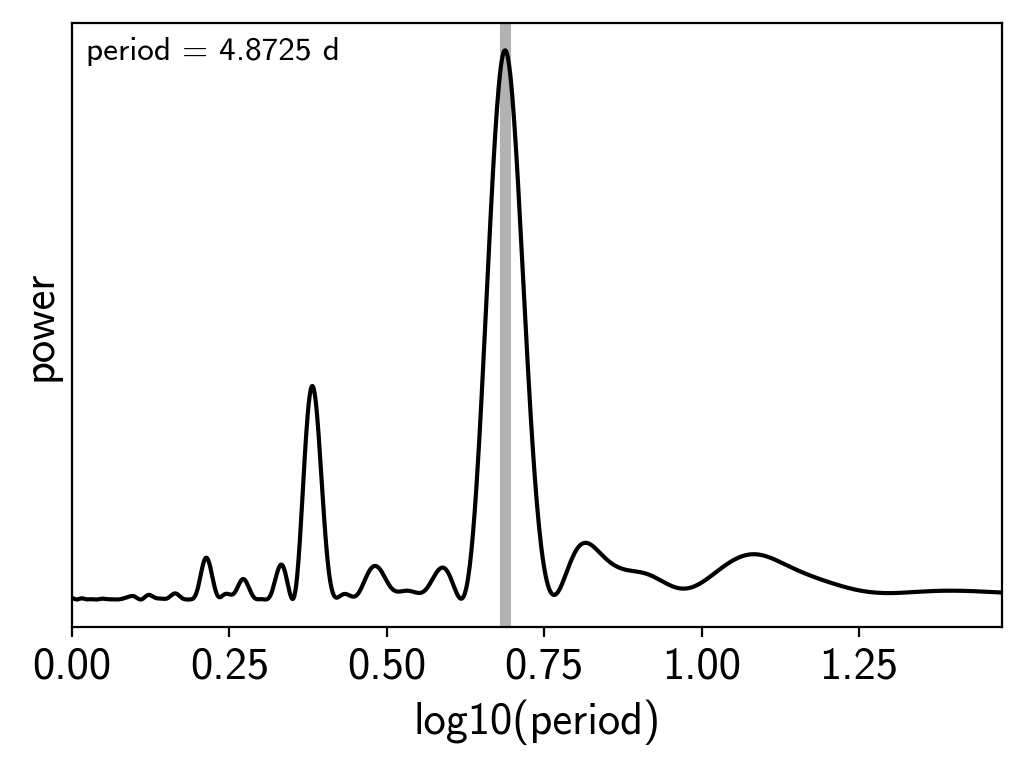

In [4]:
import exoplanet as xo

results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=1.0, max_period=30.0,
    samples_per_peak=50)

peak = results["peaks"][0]
ls_period = peak["period"]
freq, power = results["periodogram"]
plt.plot(-np.log10(freq), power, "k")
plt.axvline(np.log10(ls_period), color="k", lw=4, alpha=0.3)
plt.xlim((-np.log10(freq)).min(), (-np.log10(freq)).max())
plt.annotate("period = {0:.4f} d".format(ls_period),
             (0, 1), xycoords="axes fraction",
             xytext=(5, -5), textcoords="offset points",
             va="top", ha="left", fontsize=12)
plt.yticks([])
plt.xlabel("log10(period)")
plt.ylabel("power");

In [5]:
import pymc3 as pm
import theano.tensor as tt

def build_model(mask=None):
    if mask is None:
        mask = np.ones_like(x, dtype=bool)
    with pm.Model() as model:

        # The mean flux of the time series
        mean = pm.Normal("mean", mu=0.0, sd=10.0)

        # A jitter term describing excess white noise
        logs2 = pm.Normal("logs2", mu=2*np.log(np.min(yerr[mask])), sd=5.0)

        # A SHO term to capture long term trends
        logS = pm.Normal("logS", mu=0.0, sd=15.0, testval=np.log(np.var(y[mask])))
        logw = pm.Normal("logw", mu=np.log(2*np.pi/10.0), sd=10.0)
        term1 = xo.gp.terms.SHOTerm(log_S0=logS, log_w0=logw, Q=1/np.sqrt(2))
        
        # The parameters of the RotationTerm kernel
        logamp = pm.Normal("logamp", mu=np.log(np.var(y[mask])), sd=5.0)
        logperiod = pm.Normal("logperiod", mu=np.log(ls_period), sd=5.0)
        period = pm.Deterministic("period", tt.exp(logperiod))
        logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
        logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
        mix = pm.Uniform("mix", lower=0, upper=1.0)
        term2 = xo.gp.terms.RotationTerm(
            log_amp=logamp,
            period=period,
            log_Q0=logQ0,
            log_deltaQ=logdeltaQ,
            mix=mix
        )

        # Set up the Gaussian Process model
        kernel = term1 + term2
        gp = xo.gp.GP(kernel, x[mask], yerr[mask]**2 + tt.exp(logs2), J=6)

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        pm.Potential("loglike", gp.log_likelihood(y[mask] - mean))

        # Compute the mean model prediction for plotting purposes
        pm.Deterministic("pred", gp.predict())

        # Optimize to find the maximum a posteriori parameters
        map_soln = pm.find_MAP(start=model.test_point, vars=[mean, logs2])
        map_soln = pm.find_MAP(start=map_soln, vars=[mean, logs2, logS, logw])
        map_soln = pm.find_MAP(start=map_soln, vars=[mean, logs2, logamp, logQ0, logdeltaQ, mix])
        map_soln = pm.find_MAP(start=map_soln)
        
    return model, map_soln

model0, map_soln0 = build_model()

logp = 10,197, ||grad|| = 0.00043711: 100%|██████████| 13/13 [00:00<00:00, 324.72it/s]  
logp = 10,202, ||grad|| = 65.929: 100%|██████████| 20/20 [00:00<00:00, 258.96it/s]  
logp = 10,213, ||grad|| = 270.28: 100%|██████████| 51/51 [00:00<00:00, 269.75it/s]  
logp = 10,213, ||grad|| = 6.8898: 100%|██████████| 8/8 [00:00<00:00, 273.82it/s]


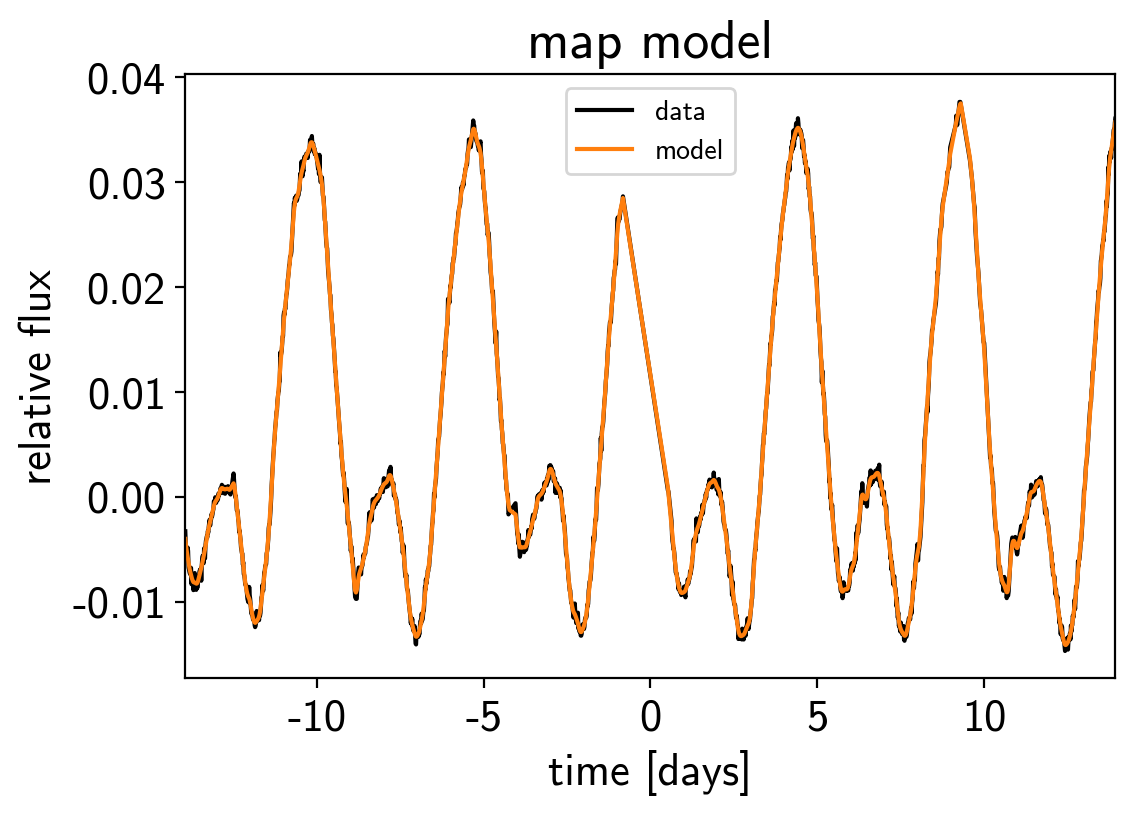

In [6]:
plt.plot(x, y, "k", label="data")
plt.plot(x, map_soln0["pred"] + map_soln0["mean"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.title("map model");

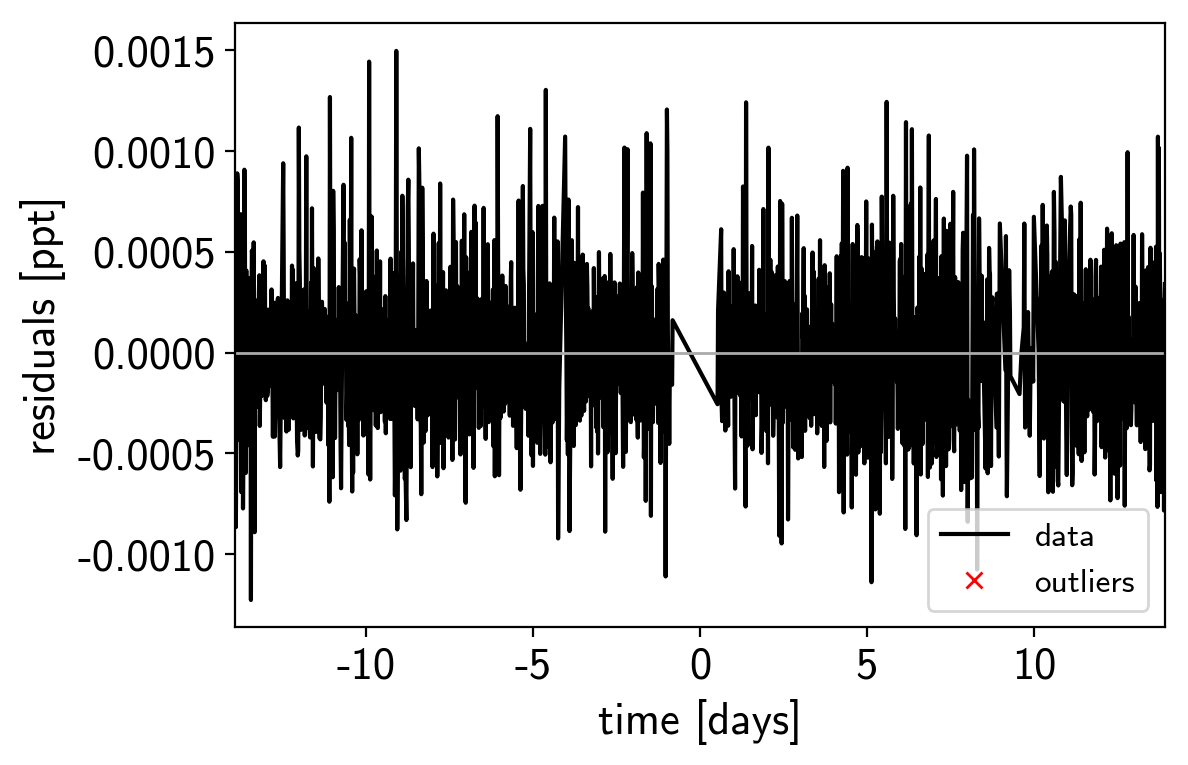

In [7]:
mod = map_soln0["pred"] + map_soln0["mean"]
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 7 * rms

plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=4)
plt.xlim(x.min(), x.max());

In [8]:
model, map_soln = build_model(mask)

logp = 10,197, ||grad|| = 0.00043711: 100%|██████████| 13/13 [00:00<00:00, 303.59it/s]  
logp = 10,202, ||grad|| = 65.929: 100%|██████████| 20/20 [00:00<00:00, 246.44it/s]  
logp = 10,213, ||grad|| = 270.28: 100%|██████████| 51/51 [00:00<00:00, 246.53it/s]  
logp = 10,213, ||grad|| = 6.8898: 100%|██████████| 8/8 [00:00<00:00, 162.98it/s]


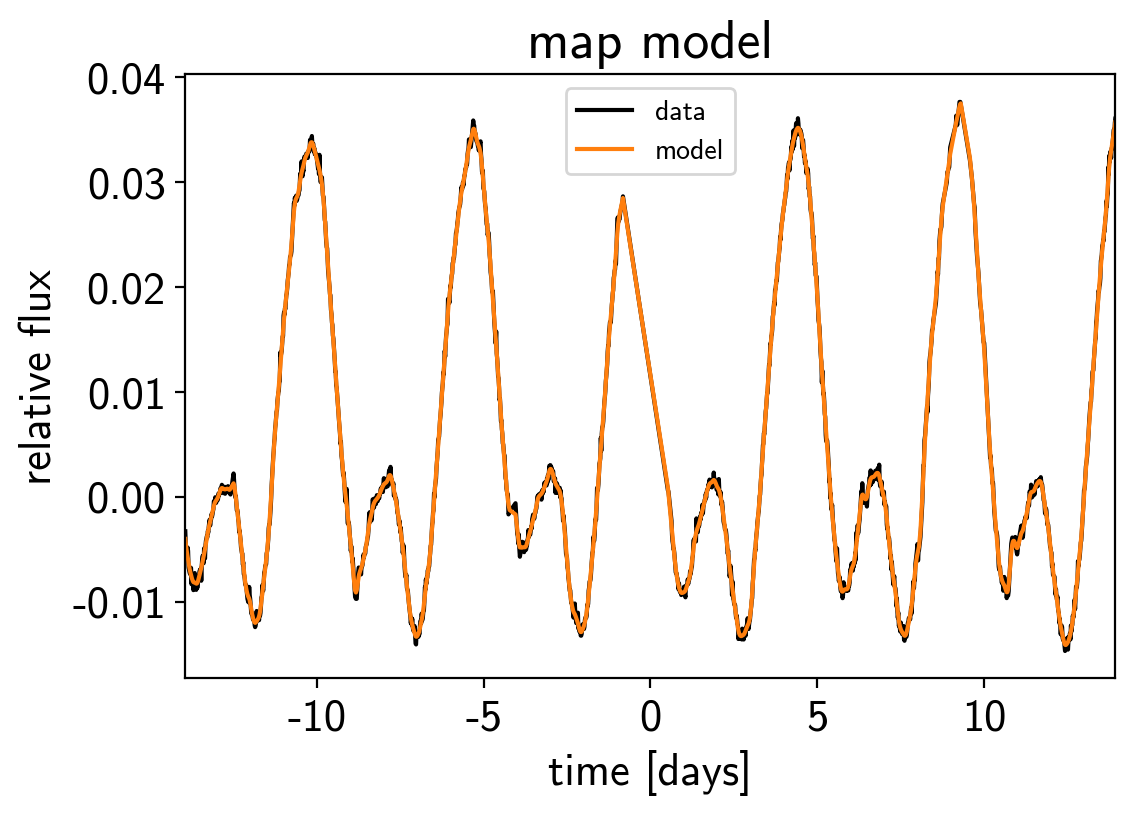

In [9]:
plt.plot(x[mask], y[mask], "k", label="data")
plt.plot(x[mask], map_soln["pred"] + map_soln["mean"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.title("map model");

In [10]:
sampler = xo.PyMC3Sampler()
with model:
    sampler.tune(tune=2000, start=map_soln, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=2000)

Sampling 2 chains: 100%|██████████| 2304/2304 [06:59<00:00,  3.97draws/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mix, logdeltaQ, logQ0, logperiod, logamp, logw, logS, logs2, mean]
Sampling 2 chains: 100%|██████████| 4100/4100 [16:32<00:00,  2.22draws/s]


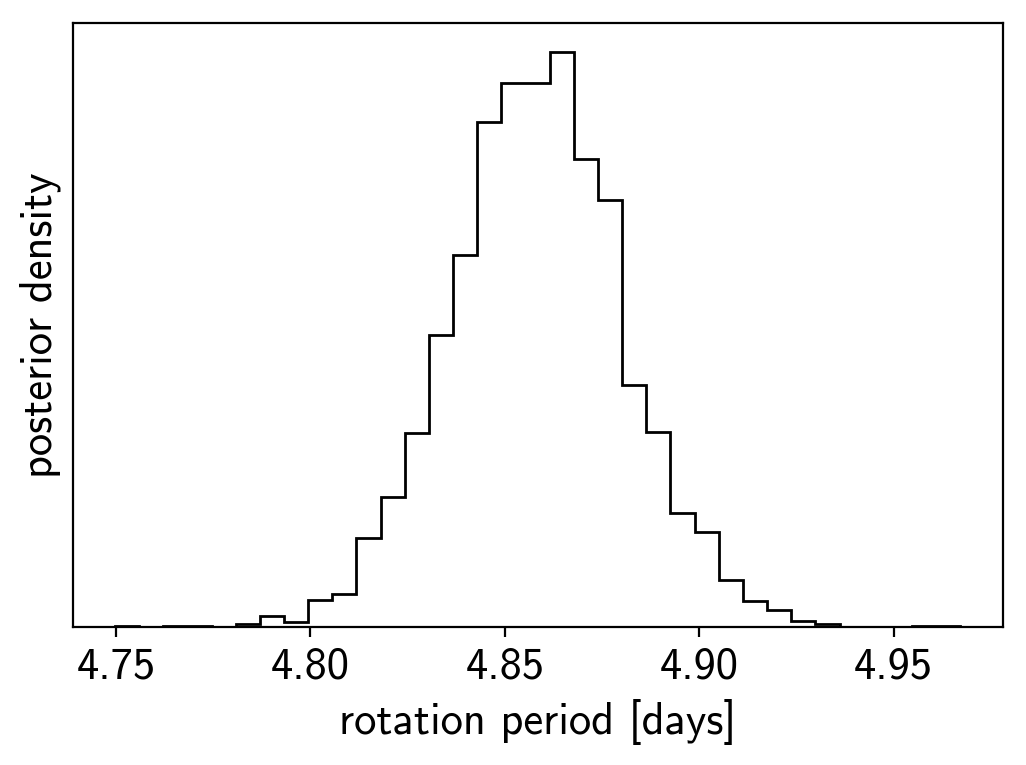

In [16]:
period_samples = trace["period"]
plt.hist(period_samples, 35, histtype="step", color="k")
plt.yticks([])
plt.xlabel("rotation period [days]")
plt.ylabel("posterior density");